# TN quantum circuit simulation using ``.qasm`` format


Here we show how to simulate quantum circuits using tensor networks.
We do this using a simple translation of the ``.qasm`` form into
``quimb.tensor`` operations.

In [1]:
%matplotlib inline
import quimb as qu
import quimb.tensor as qtn

In [2]:
def parse_qasm(qasm):
    """Parse qasm from a string.
    """
    lns = qasm.split('\n')
    n = int(lns[0])
    gates = [l.split(" ") for l in lns[1:] if l]
    return {'n': n, 'gates': gates, 'n_gates': len(gates)}

def parse_qasm_file(fname):
    """Parse a qasm file.
    """
    return parse_qasm(open(fname).read())
    
def parse_qasm_url(url):
    """Parse a qasm url.
    """
    from urllib import request
    return parse_qasm(request.urlopen(url).read().decode())

These functions just parse the ``qasm`` format into something python-readable, e.g.:

In [3]:
url_bell_pair = 'https://github.com/aspuru-guzik-group/qtorch/raw/master/Samples/bell_pair.qasm'
parse_qasm_url(url_bell_pair)

{'n': 2, 'gates': [['H', '0'], ['CNOT', '0', '1']], 'n_gates': 2}

The following url contains a slightly larger circuit acting on 30 qubits with 240 gates:

In [4]:
url = 'https://github.com/aspuru-guzik-group/qtorch/raw/master/Samples/4regRand30Node5-p1.qasm'

info = parse_qasm_url(url)

n = info['n']
gates = info['gates']
info['n_gates']

240

The circuit only contains H, CNOT, Rz and Rx gates so we'll just produce the
minimal translators for those:

In [5]:
# translate the gate sequence into quimb.tensor operations
#     note all the operator generating functions are cached

def apply_H(psi, i):
    psi.gate(qu.hadamard(), int(i))
    
def apply_CNOT(psi, i, j):
    psi.gate(qu.controlled('not'), (int(i), int(j)))
    
def apply_Rz(psi, theta, i):
    psi.gate(qu.Rz(float(theta)), int(i))
    
def apply_Rx(psi, theta, i):
    psi.gate(qu.Rx(float(theta)), int(i))

select_apply = {
    'H':    apply_H,
    'CNOT': apply_CNOT,
    'Rx':   apply_Rz,
    'Rz':   apply_Rx,
}

def apply_circuit(psi0, gates):
    # by default gate operations are inplace -> copy input
    psi = psi0.copy()
    
    # apply all the gates
    for gate in gates:
        which, args = gate[0], gate[1:]
        fn = select_apply[which]
        fn(psi, *args)
        
    # return the final state
    return psi

Now we can apply the circuit to an intitial state:

In [6]:
# initial state |0000......0000>
#     the contructor is an MPS but we are not using any MPS
#     specific features other than the 1D geometry
psi_i = qtn.MPS_computational_state('0' * n)

# remove size 1 bonds -> product state
psi_i.squeeze(inplace=True)

# run the circuit
psi_f = apply_circuit(psi_i, gates)

The state is still lazily represented as tensor network, there are many things we could now compute
efficiently, but here we'll just find the overlap with the initial state:

In [7]:
# form overlap with intial state
exp = (psi_i.H & psi_f)

Plot the resulting tensor network with colors representing the 'lightcone' of each qubit:

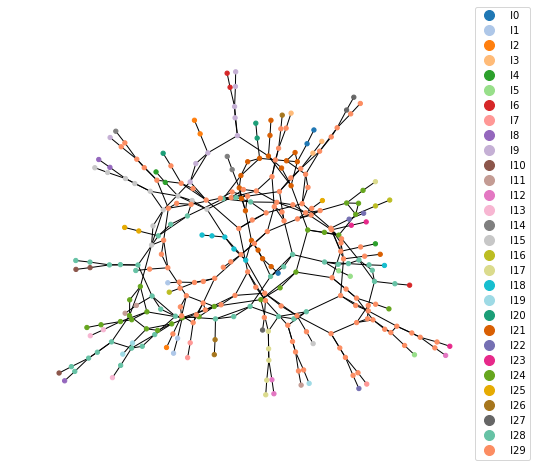

In [8]:
exp.graph(color=['I{}'.format(i) for i in range(n)])

Compute the expectation of the whole circuit:

In [9]:
(exp ^ all)

(-4.7343948999197255e-07+3.051390551313911e-05j)

Time it:

In [10]:
%%timeit
exp ^ all

8.4 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


A lot quicker (and less memory) than simulating the hilbert space of 30 qubits!
You could also try using, for example, ``exp.contract(all, backend='tensorflow')`` 
to experiment with different tensor contraction backends that potentially use the GPU.